In [780]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [781]:
def pbc(R, L):
    """
    Apply periodic boundary conditions to particle positions
    in a cubic box of side length L.

    Args:
        R (np.array): particle positions, shape (N, N 3)
        L (float): side length of cubic box
    Returns:
        np.array: particle positions, shape (N, N, 3)
    """

    return R - L * np.round(R / L)


def distance(R, L):
    """
    Compute distance table and rij vectors

    Args:
        R (np.array) : particle positions, shape (N, 3)
        L (float): side length of cubic box
    Returns:
        distance_table (np.array): distance table, shape (N, N)
        rij (np.array): rij vectors, shape (N, N, 3)
    """

    rij = R[:, np.newaxis, :] - R
    rij = pbc(rij, L)
    distance_table = np.linalg.norm(rij, axis=2)

    return distance_table, rij


def distancei(i, R, L):
    """
    Compute distance table and rij vectors for a single particle

    Args:
        i (int): particle index
        R (np.array) : particle positions, shape (N, 3)
        L (float): side length of cubic box
    Returns:
        distance_table (np.array): distance table, shape (N, )
        rij (np.array): rij vectors, shape (N, 3)
    """

    rij = R[i] - R
    rij = pbc(rij, L)
    distance_table = np.linalg.norm(rij, axis=1)

    return distance_table, rij


def PEi(i, distance_table, rc):
    """
    Compute shifted Leonord Jones potential energy for particle i

    Args:
        i (int): particle index
        distance_table (np.array): single particle distance table, shape (N, )
        L (float): cubic box side length
        rc (float): potential cutoff radius
    Return:
        pe (float): potential energy for particle i
    """

    sixth_rc = rc**-6
    vshift = 4 * sixth_rc * (sixth_rc - 1)
    rc_mask = distance_table < rc
    i_mask = np.arange(distance_table.shape[0]) != i
    mask = rc_mask & i_mask
    sixth = distance_table[mask] ** -6
    pe = np.sum(4 * sixth * (sixth - 1) - vshift)

    return pe


def Fi(i, distance_table, rij, rc):
    """
    Calculate the force experienced by particle i

    Args:
        i (int): particle index
        distance_table (np.array): single particle distance table, shape (N, )
        rij (np.array): single particle rij vectors, shape (N, 3)
        rc (float): potential cutoff radius
    Return:
        force (np.array): force on particle i, shape (d,)
    """

    N = distance_table.shape[0]
    i_mask = np.arange(N) != i
    rc_mask = distance_table < rc
    mask = rc_mask & i_mask

    sixth = distance_table[mask] ** -6

    force = 24 * np.dot(distance_table[mask] ** -2 * sixth * (2 * sixth - 1), rij[mask])

    return force


def PE(distance_table):
    """
    Calculate total potential energy.

    Args:
        distance_table (np.array): distance table, shape (N, N)
    Return:
        pe (float): total potential energy
    """

    n = distance_table.shape[0]
    # Create an upper triangular mask
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    r = distance_table[mask]  # Extract the upper triangular elements of rij
    sixth = 1 / r**6
    pe = np.sum(a=4 * sixth * (sixth - 1))

    return pe


def mc_sweep(R, L, rc, beta, eta, accept_check):
    """Perform one Monte Carlo sweep

    Args:
        R (np.array): particle positions, shape (N, d)
        L (float): cubic box side length
        rc (float): potential cutoff radius
        beta (float): inverse temperature
        eta (np.array): shape (N, d), array of Gaussian random numbers, one for each single-particle move
        accept_check (np.array): shape (natom), array of uniform random numbers, one for each single particle move
    Return:
        (int, float): (naccept, dR), the number of accepted single-particle moves, and the change in energy
    """
    N, d = R.shape
    naccept = 0
    dE = 0
    R = R.copy()

    for i in range(N):
        nR = R.copy()
        nR[i] = pbc(nR[i] + eta[i], L)
        distance_table, rij = distancei(i, R, L)
        PE_old = PEi(i, distance_table, rc)
        distance_new, rij_new = distancei(i, nR, L)
        PE_new = PEi(i, distance_new, rc)
        dEi = PE_new - PE_old
        p = -beta * dEi
        if p > np.log(accept_check[i]):
            R[i] = nR[i]
            naccept += 1
            dE += dEi

    return naccept, dE, R


def mc_sweep_smart(R, L, rc, beta, eta, accept_check, sig):
    """Perform one Monte Carlo sweep using smart Monte Carlo moves

    Args:
        R (np.array): particle positions, shape (N, d)
        L (float): cubic box side length
        rc (float): potential cutoff radius
        beta (float): inverse temperature
        eta (np.array): shape (natom, ndim), array of Gaussian random
        numbers, one for each single-particle move
        accept_check (np.array): shape (natom), array of uniform random numbers, one for each single-particle move
        sig (float): width of Gaussian random numbers (eta)
    Return:
        (int, float): (naccept, dE), the number of accepted single-particle moves, and the change in energy
    """
    tau = 0.5 * sig**2

    N, d = R.shape
    naccept = 0
    dE = 0
    R = R.copy()

    for i in range(N):
        distance_table, rij = distancei(i, R, L)
        F_old = Fi(i, distance_table, rij, rc)
        PE_old = PEi(i, distance_table, rc)
        dr = eta[i] + tau * beta * F_old

        nR = R.copy()
        nR[i] = pbc(nR[i] + dr, L)
        distance_new, rij_new = distancei(i, nR, L)
        F_new = Fi(i, distance_new, rij_new, rc)
        PE_new = PEi(i, distance_new, rc)

        dEi = PE_new - PE_old
        T_forward = -norm(dr - tau * beta * F_old) ** 2 / (4 * tau)
        T_back = -norm(-dr - tau * beta * F_new) ** 2 / (4 * tau)
        p = T_back - T_forward
        p += -beta * dEi

        if p > np.log(accept_check[i]):
            R[i] = nR[i]
            naccept += 1
            dE += dEi

    return naccept, dE, R


def generate_eta(N, d, sigma):
    """
    Generate Gaussian random numbers for Metropolis Monte Carlo moves

    Args:
        N (int): number of particles
        d (int): dimension of space
        sigma (float): width of Gaussian random numbers
    Returns:
        np.array: array of shape (N, d) of Gaussian random numbers
    """

    return np.random.normal(loc=0, scale=sigma, size=(N, d))


def generate_accept_check(N):
    """
    Generate uniform random numbers for Monte Carlo acceptance checks

    Args:
        N (int): number of particles
    Returns:
        np.array: array of shape (N,) of uniform random numbers
    """
    return np.random.uniform(low=0, high=1, size=N)


def generate_eta_smart(N, d, sigma, xadjust):
    """
    Generate Gaussian random numbers for Smart Monte Carlo moves

    Args:
        N (int): number of particles
        d (int): dimension of space
        sigma (float): width of Gaussian random numbers
        xadjust (float): adjustment to Gaussian random numbers
    Returns:
        np.array: array of shape (N, d) of Gaussian random numbers

    """
    return np.random.normal(xadjust, sigma, (N, d))


def pair_correlation(distances, L, dr):
    """
    Calculate the pair correlation function g(r)

    Args:
        distances (np.array): array of distances, shape (nsteps, N, N)
        L (float): box side length
        dr (float): size of bins
    Returns:
        r (np.array): array of bin centers, shape (nbins,)
        g (np.array): pair correlation function, shape (nbins,)
    """
    N = distances.shape[1]
    nsteps = distances.shape[0]
    # Remove self-distance
    mask = ~np.eye(N, dtype=bool)
    mask = np.broadcast_to(mask, (nsteps, N, N))
    distances = distances.copy()[mask].flatten()
    # Calculate histogram
    nbins = int(L / 2 / dr)
    histogram = np.histogram(distances, bins=nbins, range=(0, nbins * dr))
    counts = histogram[0]
    r = (histogram[1] + dr / 2)[:-1]  # centers of the bins
    # Shell volume
    outer_shell_volume = 4 * np.pi / 3 * (r + dr / 2) ** 3
    inner_shell_volume = 4 * np.pi / 3 * (r - dr / 2) ** 3
    shell_volume = outer_shell_volume - inner_shell_volume
    # normalize and average
    V = L**3
    rho = N / V
    normalization = rho * shell_volume  # expected count
    g = counts / normalization
    g /= N  # Average over particles
    g /= nsteps  # Average over time

    return r, g


def actime(E):
    """
    Calculate the autocorrelation time for a time series E

    Args:
        E (np.array): array of energies, shape (N,)
    Returns:
        (float, int): (kappa, tcutoff), the autocorrelation time and the cutoff time
    """

    mu = np.mean(E)
    std = np.std(E, ddof=1)
    N = E.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (E[: N - t] - mu) * (E[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return kappa, tcutoff


def legal_kvecs(maxn, lbox):
    """
    Calculate k vectors commensurate with a cubic box.

    Consider only k vectors in the all-positive octant of reciprocal space.

    Args:
        maxn : maximum value for nx, ny, nz; maxn+1 is number of k-points along each axis
        lbox : side length of cubic cell

    Returns:
        array of shape (nk, ndim): collection of k vectors
    """
    n = np.arange(maxn + 1)
    n = np.vstack(np.meshgrid(n, n, n)).reshape(3, -1).T
    kvecs = 2 * np.pi / lbox * n
    tmp = np.array(kvecs[:, 0])
    kvecs[:, 0] = kvecs[:, 1]
    kvecs[:, 1] = tmp
    return kvecs


def calc_rhok(kvecs, Rs):
    """
    Calculate the fourier transform of particle density.

    Args:
        kvecs (np.array): array of k-vectors, shape (nk, d)
        pos (np.array): particle positions, shape (nsteps, N, d)
    Returns:
        array of shape (nk,): fourier transformed density rho_k
    """
    return np.sum(np.exp(-1j * (Rs @ kvecs.T)), axis=1)


def calc_sk(maxn, L, Rs):
    """
    Calculate the structure factor S(k).

    Args:
        maxn (int): maximum value for nx, ny, nz; maxn+1 is number of k-points along each axis
        L (float): side length of cubic cell
        Rs (np.array): particle positions, shape (nsteps, N, d)
    Returns:
        unique_kmags (np.array): array of unique k magnitudes, shape (nk,)
        sk (np.array): structure factor s(k), shape (nk, )

    """
    Rs = Rs.copy()

    if Rs.ndim == 2:
        Rs = Rs[np.newaxis, :, :]

    nsteps = Rs.shape[0]
    N = Rs.shape[1]
    kvecs = legal_kvecs(maxn, L)
    kmags = np.linalg.norm(kvecs, axis=1)
    unique_kmags = np.unique(kmags)
    Nunique = unique_kmags.shape[0]
    unique_sks = np.zeros((nsteps, Nunique), dtype=np.complex64)
    rhok = calc_rhok(kvecs, Rs)
    sk = rhok * rhok.conj() / N

    for i, k in enumerate(unique_kmags):
        mask = kmags == k
        unique_sks[:, i] = np.mean(sk[:, mask], axis=1)

    return unique_kmags, np.mean(unique_sks, axis=0)


def diffusion_constant(vacf):
    """
    Calculate the diffusion constant from the
    velocity-velocity auto-correlation function (vacf).

    Args:
        vacf (np.array): shape (nt,), vacf sampled at
        nt time steps from t=0 to nt*dt. dt is set to 0.032.
    Returns:
        float: the diffusion constant calculated from the vacf.
    """
    dt = 0.032
    return np.trapz(vacf, dx=dt) / 3


def stderr(a):
    kappa, tcutoff = actime(a)
    N = a.shape[0]
    std = np.std(a, ddof=1)

    return std / np.sqrt(N / kappa)


def F_all(rij, distance_table):
    """
    Compute force on all particles

    Args:
        rij (np.array) : distance vectors, shape (nparticles, nparticles, 3)
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Returns:
        np.array: force on all particles, shape (nparticles, 3)
    """

    n = rij.shape[0]
    mask = ~np.eye(n, dtype=bool)
    rij = rij[mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[mask].reshape(n, -1)  # Remove self-interaction
    sixth = (1 / distance_table) ** 6
    factor = (1 / distance_table**2) * sixth * (2 * sixth - 1)
    factor = factor[:, :, np.newaxis]
    force = np.sum(factor * rij, axis=1)

    return 24 * force


def InitPositionCubic(N, L):
    """
    Places Ncube^3 atoms in a cubic box

    Args:
        Ncube (int): cube root number of atoms
        L (float): box side length
    Returns:
        np.array: positions, shape (Ncube**3, 3)
    """
    import math

    Ncube = math.ceil(N ** (1 / 3))
    rs = L / Ncube
    roffset = L / 2 - rs / 2
    x = np.linspace(-roffset, roffset, Ncube)
    # Create a grid of positions using numpy broadcasting
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the positions into a single array
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    return position


def simulateMC(N, L, T, rc, sigma, steps):
    beta = 1 / T
    R = InitPositionCubic(N, L)
    Rs = np.zeros((steps, N, 3))
    Es = np.zeros(steps)
    distances = np.zeros((steps, N, N))
    acceptance_ratios = np.zeros(steps)

    for t in range(steps):
        eta = generate_eta(N, 3, sigma)
        accept_check = generate_accept_check(N)
        naccept, dE, R = mc_sweep(R, L, rc, beta, eta, accept_check)

        Rs[t] = R

        distance_table, rij = distance(R, L)
        E = PE(distance_table)
        Es[t] = E
        distances[t] = distance_table
        acceptance_ratios[t] = naccept / N

    return Rs, Es, distances, acceptance_ratios


def simulateMC_smart(N, L, T, M, rc, sigma, steps, dt):
    beta = 1 / T
    R = InitPositionCubic(N, L)
    Rs = np.zeros((steps, N, 3))
    Es = np.zeros(steps)
    distances = np.zeros((steps, N, N))
    acceptance_ratios = np.zeros(steps)

    distance0, rij0 = distance(R, L)
    F = F_all(rij0, distance0)

    for t in range(steps):
        xadjust = F / (2 * M) * dt**2

        eta = generate_eta_smart(N, 3, sigma, xadjust)
        accept_check = generate_accept_check(N)
        naccept, dE, R = mc_sweep_smart(R, L, rc, beta, eta, accept_check, sigma)

        Rs[t] = R

        distance_table, rij = distance(R, L)
        F = F_all(rij, distance_table)
        E = PE(distance_table)
        Es[t] = E
        distances[t] = distance_table
        acceptance_ratios[t] = naccept / N

    return Rs, Es, distances, acceptance_ratios

### 1. 



Detailed balance requires $P(x)T(x \rightarrow y) = P(y)T(y \rightarrow x)$

Setting $A(x \rightarrow y) = \frac{P(y)T(y \rightarrow x)}{P(x)T(x \rightarrow y)}$ and $A(y\rightarrow x) = 1$ provides detailed balance such that:

$P(x)T(x \rightarrow y)A(x\rightarrow y) = P(y)T(y \rightarrow x)$ holds

Then, we have $A(x\rightarrow y) = min(1, \frac{P(y)T(y \rightarrow x)}{P(x)T(x \rightarrow y)})$

### 1.

# 2.

In [782]:
N = 64
L = 4.0
M = 48.0
T = 2.0
rc = 2.5
steps = 100
sigmas = np.array([0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3])

Rs, Es, distances, acceptance_ratios = (
    np.zeros((7, steps, N, 3)),
    np.zeros((7, steps)),
    np.zeros((7, steps, N, N)),
    np.zeros((7, steps)),
)

for i, sigma in enumerate(sigmas):
    Rs[i], Es[i], distances[i], acceptance_ratios[i] = simulateMC(
        N, L, T, rc, sigma, steps
    )

    print(f"sigma = {sigma}, acceptance ratio = {np.mean(acceptance_ratios[i])}")

sigma = 0.01, acceptance ratio = 0.88
sigma = 0.03, acceptance ratio = 0.644375
sigma = 0.05, acceptance ratio = 0.49015625
sigma = 0.1, acceptance ratio = 0.1978125
sigma = 0.15, acceptance ratio = 0.08265625
sigma = 0.2, acceptance ratio = 0.03234375
sigma = 0.3, acceptance ratio = 0.00453125


We see that a standard deviation of $0.05$ will give us an acceptance ratio of about $0.48$. 

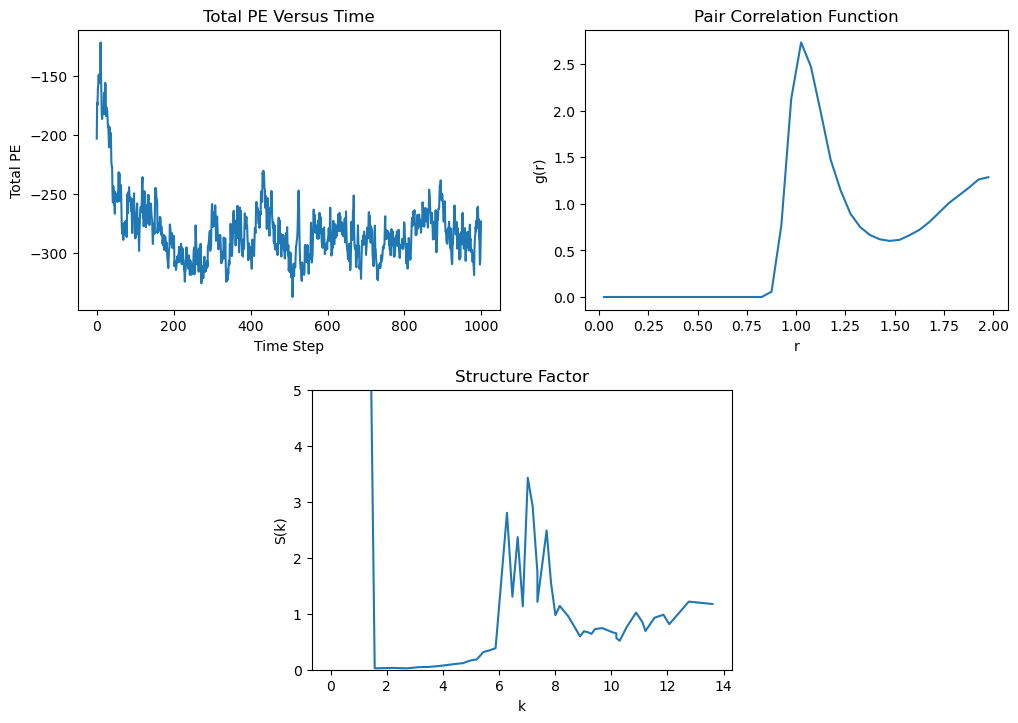

Average Energy: -281.44792111431485
Standard Error:  7.045630393260228
Total Number of MC Steps:  32545.0


In [784]:
N = 64
L = 4.0
M = 48.0
T = 2.0
rc = 2.5
sigma = 0.05
steps = 1000
dr = 0.05

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sigma, steps)

kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)

kmags, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function")

axes[1, 0].plot(kmags, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor")
axes[1, 0].set_ylim(0, 5)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

### 3. 

Here I have chosen $\sigma = 0.3$, taken from Q2.

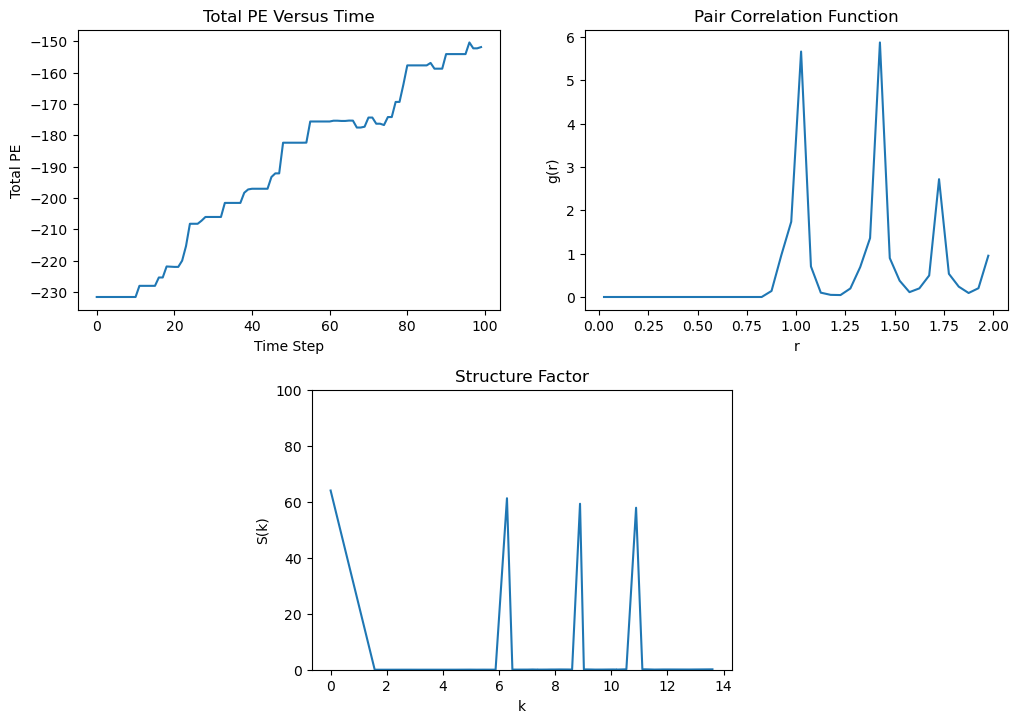

Average Energy: -190.43727749713133
Standard Error:  16.349377644837077
Total Number of MC Steps:  46.0


In [789]:
N = 64
L = 4.0
M = 48.0
T = 2.0
rc = 2.5
sigma = 0.3
steps = 100
dr = 0.05

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sigma, steps)

kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmags, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function")

axes[1, 0].plot(kmags, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor")
axes[1, 0].set_ylim(0, 100)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

Here I have chosen $\sigma = 0.01$, taken from Q2.

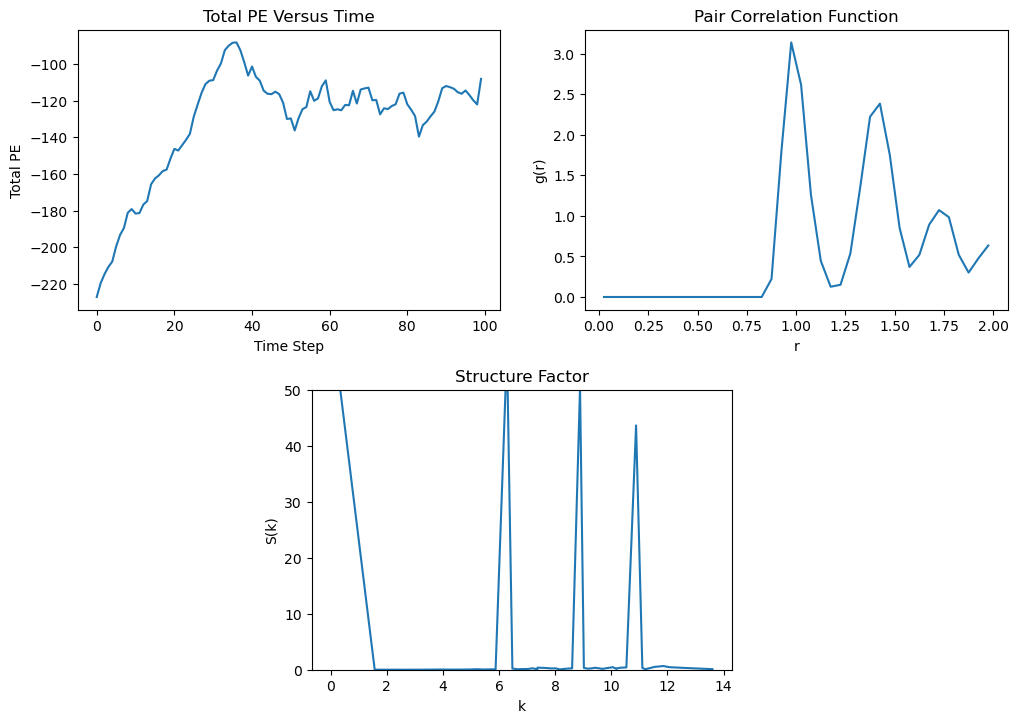

Average Energy: -131.59878549401097
Standard Error:  13.068593856158166
Total Number of MC Steps:  5500.0


In [791]:
N = 64
L = 4.0
M = 48.0
T = 2.0
rc = 2.5
sigma = 0.01
steps = 100
dr = 0.05

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sigma, steps)

kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmags, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function")

axes[1, 0].plot(kmags, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor")
axes[1, 0].set_ylim(0, 50)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

In the case of a low acceptance ratio, fewer moves are made over the 100 time steps, and so the system does not equilibrate during the simulation. In the case of high accpetance rate, physically improbable moves are made and so the system does not settle into a stable state over the 100 timesteps. Both of these cases require longer simulation durations to reach a stable state.

### 4.

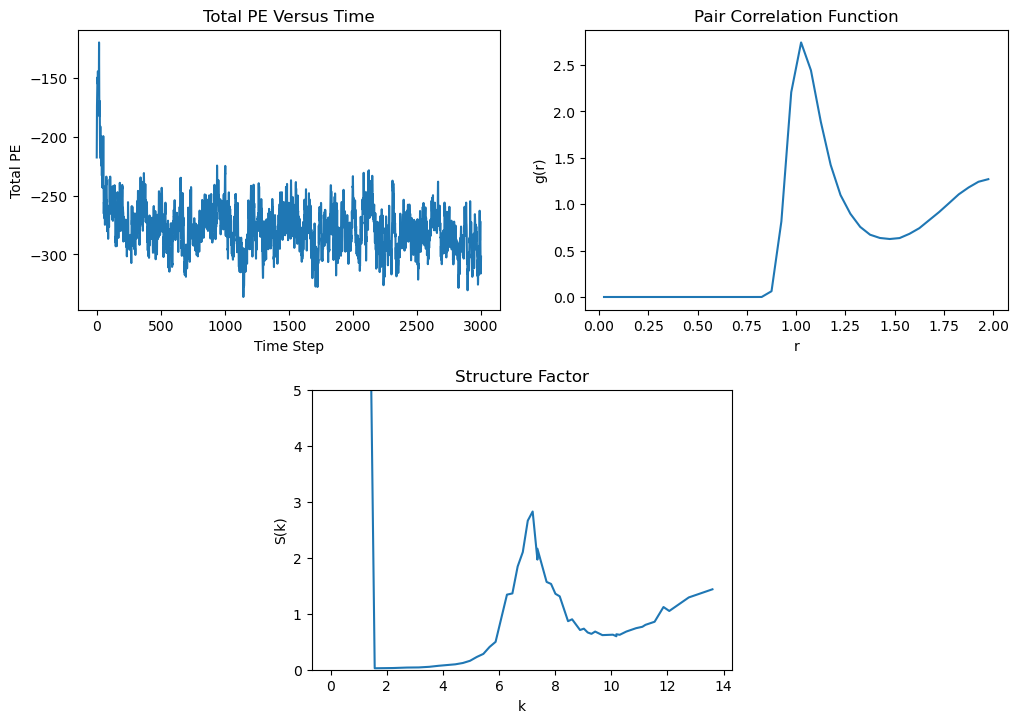

Average Energy: -277.3820121304057
Standard Error:  2.9477306336882605
Total Number of MC Steps:  97232.0


In [779]:
N = 64
L = 4.0
M = 48.0
T = 2.0
rc = 2.5
sigma = 0.05
steps = 3000
dr = 0.05

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sigma, steps)
kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmags, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function")

axes[1, 0].plot(kmags, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor")
axes[1, 0].set_ylim(0, 5)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

### 5.

$T = 0.5$:

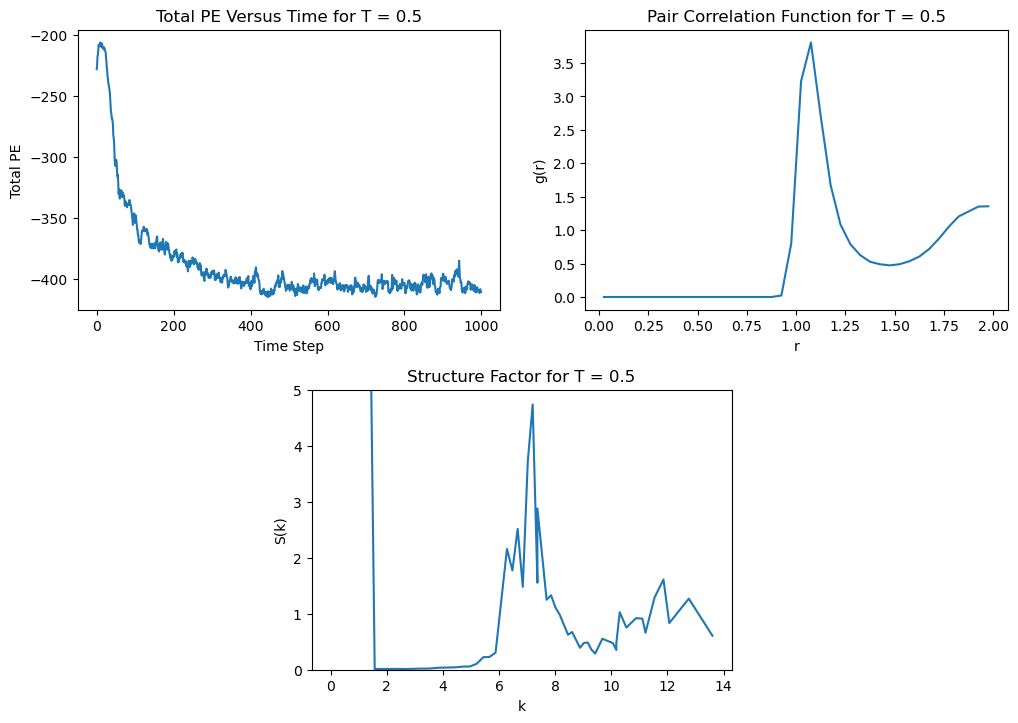

In [764]:
L = 4.0  # box length
rho = 1.0  # number density
N = 64  # particle number
M = 48.0  # mass
T = 0.5  # Temperature
R = InitPositionCubic(N, L)
sig = 0.05
rc = 2.5
steps = 1000

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sig, steps)
kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmag, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time for T = 0.5")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function for T = 0.5")

axes[1, 0].plot(kmag, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor for T = 0.5")
axes[1, 0].set_ylim(0, 5)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

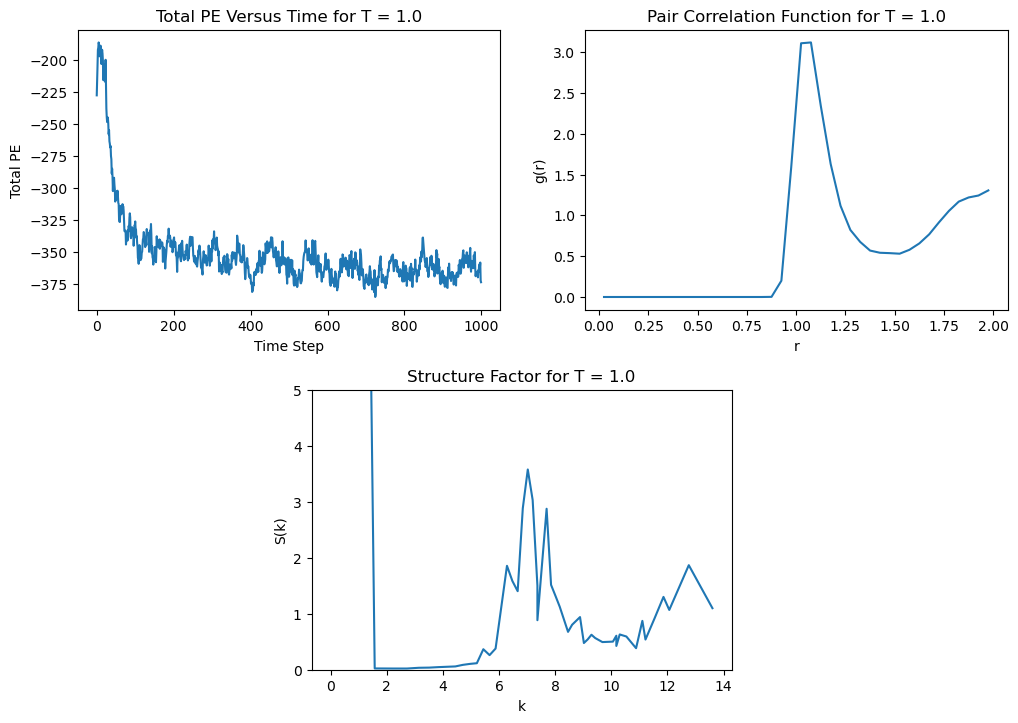

In [774]:
L = 4.0  # box length
rho = 1.0  # number density
N = 64  # particle number
M = 48.0  # mass
T = 1.0  # Temperature
R = InitPositionCubic(N, L)
sig = 0.05
rc = 2.5
steps = 1000

Rs, Es, distances, acceptance_ratios = simulateMC(N, L, T, rc, sig, steps)
kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmag, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time for T = 1.0")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function for T = 1.0")

axes[1, 0].plot(kmag, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor for T = 1.0")
axes[1, 0].set_ylim(0, 5)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

We see a higher average energy, with larger fluctuations at T = 1. Further, we get more pronounced peaks in the structure factor. The pair correlation does not markedly change. This behavior is the same that we saw in HW3.

### 6.

$dr = \eta + \tau\beta \cdot F_{old}$

$T(x \rightarrow x') = \exp{\frac{-(dr - \tau\beta \cdot F_{old})^{2}}{4\tau}}$

$T(x' \rightarrow x) = \exp{\frac{-(-dr - \tau\beta \cdot F_{new})^{2}}{4\tau}}$

$A(x \rightarrow x') = \frac{T(x' \rightarrow x)}{T(x \rightarrow x')} = \exp{(\frac{-(-dr - \tau\beta \cdot F_{new})^{2}}{4\tau} - \frac{-(dr - \tau\beta \cdot F_{old})^{2}}{4\tau})}$

### 7.

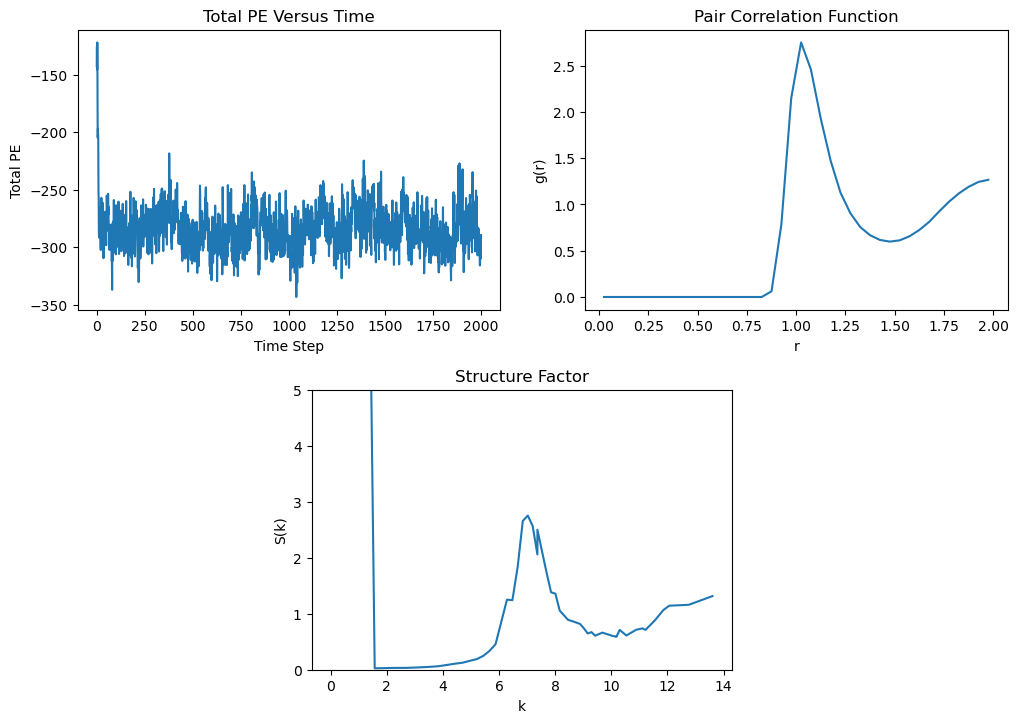

Average Energy: -284.4892311544125
Standard Error:  1.7135138073077671
Total Number of MC Steps:  102912.0


In [778]:
L = 4.0  # box length
rho = 2.0  # number density
N = 64  # particle number
M = 48.0  # mass
T = 2  # Temperature
R = InitPositionCubic(N, L)
sig = 0.05
rc = 2.5
steps = 2000
dt = 0.01

Rs, Es, distances, acceptance_ratios = simulateMC_smart(
    N, L, T, M, rc, sigma, steps, dt
)

kappa, tcutoff = actime(Es)
r, g = pair_correlation(distances[tcutoff:], L, dr)
kmag, sk = calc_sk(5, L, Rs[tcutoff:])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(Es)
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Total PE")
axes[0, 0].set_title("Total PE Versus Time")

axes[0, 1].plot(r, g)
axes[0, 1].set_xlabel("r")
axes[0, 1].set_ylabel("g(r)")
axes[0, 1].set_title("Pair Correlation Function")

axes[1, 0].plot(kmag, sk.real)
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("S(k)")
axes[1, 0].set_title("Structure Factor")
axes[1, 0].set_ylim(0, 5)

# remove the last plot from the axes and center the third one
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.32, 0.08, 0.35, 0.35])
plt.show()

print("Average Energy:", np.mean(Es))
print("Standard Error: ", stderr(Es))
print("Total Number of MC Steps: ", np.sum(N * acceptance_ratios))

For $T = 2$ and 2000 steps, we see a slight decrease in the average energy from -279 for metropolis to -282 for the smart MC. We see about half as large of a standard error, decreasing from 3 to 1.8. We also see a significant increase in accpeted moves from 65,000 to 103,000. The smart MC only took a few more seconds to run, likely owing to the additional force calculations for the $\eta$ vector's $x_{adjust}$ parameter. Better code design may reduce this additional runtime to be unnoticeable. 

Due to the lower standard error and increase in accepted moves, we can conclude that the smart MC is more efficient. That is, it will arrive at a stable solution more rapidly than metropolis MC.